In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import sys
sys.path.insert(1, '/home/simao/projects_sync/codes/tight-binding-test/src/')
sys.path.insert(1, '/home/simao/projects_sync/codes/git_rgf')
import band_structure as bs
import RGF_src as rgf

# Testing Green's functions 2dtb
Use this one instead of graphene to test the TB2D lattice

In [2]:
width=3
length=6
twist = False
k = 0
lead = 20


# set the relevant quantities
gramag = rgf.rgf()
gramag.set_2dtb_nanoribbon(width, length, twist, k, ander=0.0)


C = gramag.C
S = gramag.S



# Anderson = np.zeros([C,S])
# Anderson[2,2] = 10
# ander = 1
# Anderson = np.random.random([C,S])*ander
# gramag.Anderson = Anderson

    

gramag.build_spin()
gramag.build_vels_hsample()
gramag.generate_hamiltonian(lead, lead)

NL = gramag.NL
N = gramag.N
L = lead
R = lead



# list of complex energies
eta = 0.4
NE = 10
energies = np.linspace(0,1.0, NE)
zs = energies + eta*1j


# Testing 2DTB with double unit  cell
Complete example to calculate the average operator with Keldysh

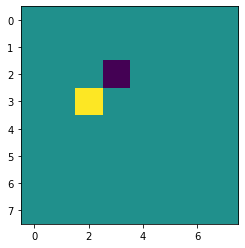

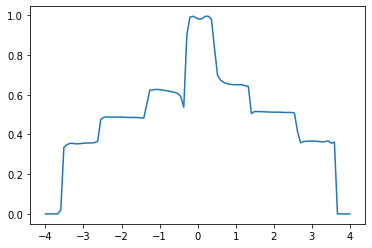

In [55]:
import RGF_src as rgf
import numpy as np
import matplotlib.pyplot as plt

# width and length of sample
width=4
length=6

# twist = True has periodic boundary conditions along 
# the transverse direction. twist = False does not
twist = False
k = 0

# set the lattice geometry and Hamiltonian. 
# ander is the Anderson disorder strength 
sys = rgf.rgf()
sys.set_2dtb_nanoribbon_large(width, length, twist, k, ander=0.1)
No = sys.No # number of orbitals per unit cell
C  = sys.C  # number of sites in the cross section (No*width)
S  = sys.S  # number of sites in the sample (C*length)

# Build the velocity operators
sys.build_vels_hsample()

# Velocity operator defined in slice 2
n = 2 
a = C*n
b = a+C
op_local = sys.vx[a:b,a:b]*1.0

# Erase all matrix elements except those at y=1
y = 1
vxp = op_local*1.0
vxp[No*y:No*(y+1),No*y:No*(y+1)] = 0
op_local -= vxp

# Represent the operator (only defined in the slice)
plt.imshow(np.imag(op_local))
plt.show()

# list of Fermi energies with small imaginary part
eta = 1e-5
NE = 100
energies = np.linspace(-4,4.0, NE)
zs = energies + eta*1j

# calculate average of operator with keldysh formalism
keld1, keld2, keld3 = sys.keldysh(zs,n, op_local)
kelsurf = np.real(keld1 - keld2)/2.0
plt.plot(energies, kelsurf)
plt.show()

# Testing the Green's functions with a graphene nanoribbon

In [2]:
width=3
length=6
twist = False
k = 0
lead = 12


# set the relevant quantities
gramag = rgf.rgf()
gramag.set_graphene_nanoribbon_rashba(width, length, twist, k, ander=1.0)


C = gramag.C
S = gramag.S
No = gramag.No



# Anderson = np.zeros([C,S])
# Anderson[2,2] = 10
ander = 1
Anderson = np.random.random([C,S])*ander
gramag.Anderson = Anderson

    

gramag.build_spin()
gramag.build_vels_hsample()
gramag.generate_hamiltonian(lead, lead)

NL = gramag.NL
N = gramag.N
L = lead
R = lead



# list of complex energies
eta = 0.4
NE = 10
energies = np.linspace(0,1.0, NE)
zs = energies + eta*1j


## Testing the surface Green's functions

In [3]:
# Left lead Hamiltonian
a = 0; b = C*L
HL = gramag.H0[a:b,a:b]*1.0
print(HL.shape)

# Right lead Hamiltonian
c = C*(L+S); d = C*(L+S+R)
HR = gramag.H0[c:d,c:d]*1.0
print(HR.shape)


(288, 288)
(288, 288)


In [4]:

g_surf_L_RGF, g_surf_R_RGF = gramag.build_surfaces(zs)


g_surf_L  = np.zeros([NE,C,C], dtype=complex) # Surface Green's function of the left lead G00
g_surf_R  = np.zeros([NE,C,C], dtype=complex) # Surface Green's function of the right lead G_{N+1,N+1}

for ee,z in enumerate(zs):
    print(ee, end=" ")
    # zn = np.conjugate(z)
    
    # Surface Green's function of left lead
    a=C*(L-1); b=C*L
    g_surf_L[ee,:,:] = np.linalg.inv(np.eye(L*C)*z - HL)[a:b,a:b]
    
    # Surface Green's function of the right lead
    a=0; b=C
    g_surf_R[ee,:,:] = np.linalg.inv(np.eye(R*C)*z - HR)[a:b,a:b]
    

0 1 2 3 4 5 6 7 8 9 

norm 1.4927428470074604e-16
left surface


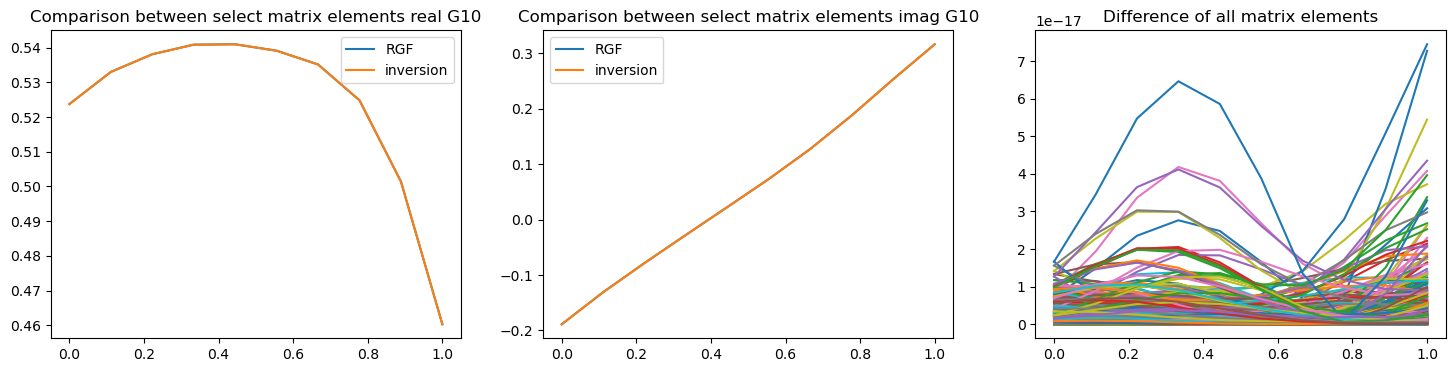

norm 1.4927428452315035e-16
right surface


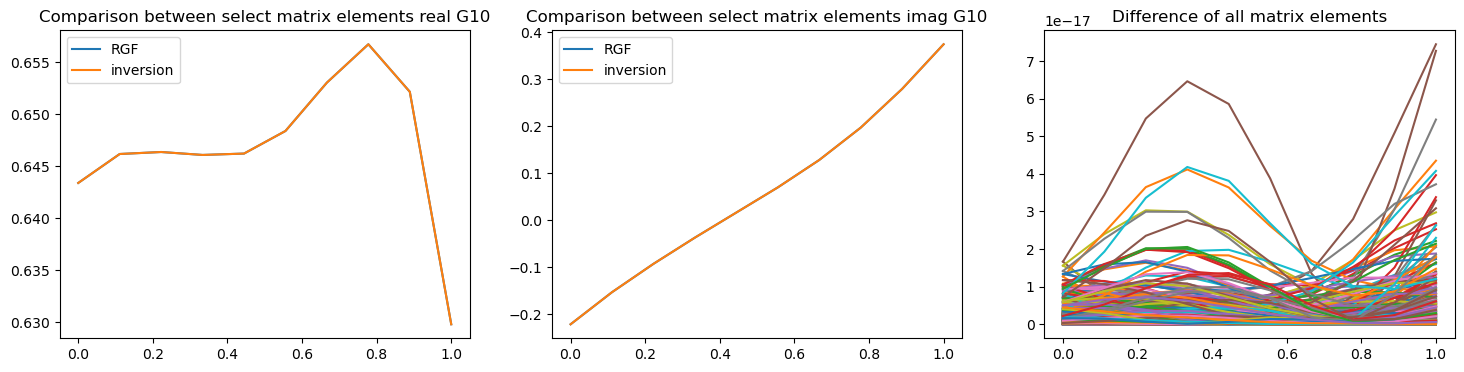

In [5]:

names = ["left surface", "right surface"]
for RGF, exact, name in zip([g_surf_L_RGF,g_surf_R_RGF],[g_surf_L,g_surf_R], names):
    
    dif = np.zeros([C,C,NE])
    for i in range(C):
        for j in range(C):
            dif[i,j,:] = abs(RGF[i,j,:] - exact[:,i,j])**2
    
    dE = energies[1] - energies[0]
    norm = dif.sum()*dE
    print("norm",norm*dE)

    print(name)
    fig, axs = plt.subplots(1,3,figsize=(18,4))
    i=1; j=0
    axs[0].set_title(f"Comparison between select matrix elements real G{i}{j}")
    axs[0].plot(energies,np.real(RGF[i,j,:]), label="RGF")
    axs[0].plot(energies,np.real(exact[:,i,j]), label="inversion")
    axs[0].legend()
    
    axs[1].set_title(f"Comparison between select matrix elements imag G{i}{j}")
    axs[1].plot(energies,np.imag(RGF[i,j,:]), label="RGF")
    axs[1].plot(energies,np.imag(exact[:,i,j]), label="inversion")
    axs[1].legend()
    
    for i in range(C):
        for j in range(C):
            p = np.real(dif[i,j,:])
            axs[2].plot(energies,p)
    axs[2].set_title("Difference of all matrix elements")
    
    plt.show()

## Testing surface left and right of a slice
These have to be identical to the leads if there is no disorder

In [6]:
# define slice
n = 2

# Hamiltonian left of slice
c = 0; d = C*(n+L); NL_slice = d-c
HL_slice = gramag.H0[c:d,c:d]*1.0
print(HL_slice.shape)

# Hamiltonian right of slice
c = C*(n+L+1); d = N; NR_slice = d-c
HR_slice = gramag.H0[c:d,c:d]*1.0
print(HR_slice.shape)

(336, 336)
(360, 360)


In [7]:

g_surf_Lslice  = np.zeros([NE,C,C], dtype=complex)
g_surf_Rslice  = np.zeros([NE,C,C], dtype=complex)


for ee,z in enumerate(zs):
    print(ee, end=" ")
    zn = np.conjugate(z)
    
    
    # Surface Green's function of left of slice
    a=C*(n+L-1); b=C*(n+L)
    g_surf_Lslice[ee,:,:] = np.linalg.inv(np.eye(NL_slice)*z - HL_slice)[a:b,a:b]
    
    # Surface Green's function of the right of slice
    a=0; b=C
    g_surf_Rslice[ee,:,:] = np.linalg.inv(np.eye(NR_slice)*z - HR_slice)[a:b,a:b]
    

0 1 2 3 4 5 6 7 8 9 

In [8]:
GL = gramag.build_surface_GL(zs, n)
GR = gramag.build_surface_GR(zs, n)

norm 1.7440995233145272e-19
left surface


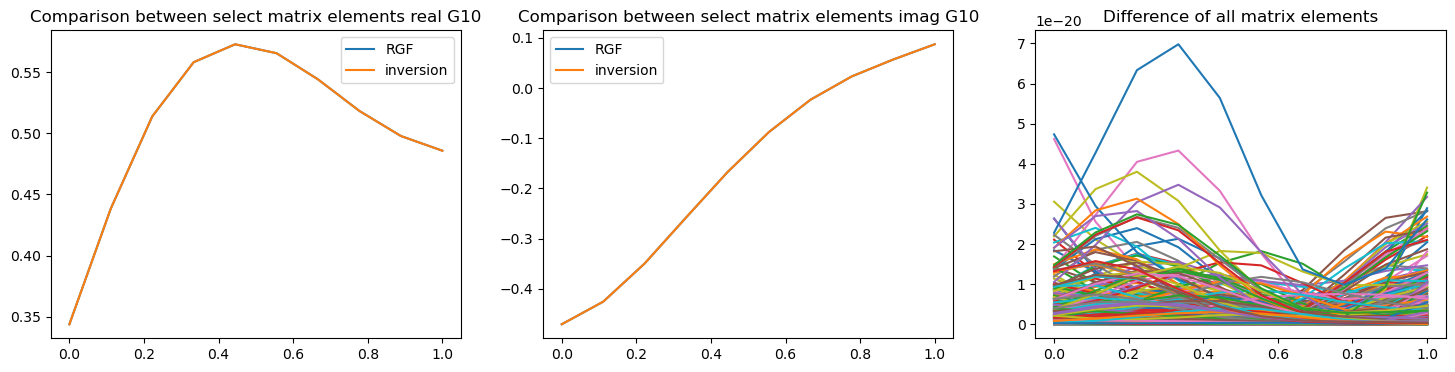

norm 5.7732516787371456e-21
right surface


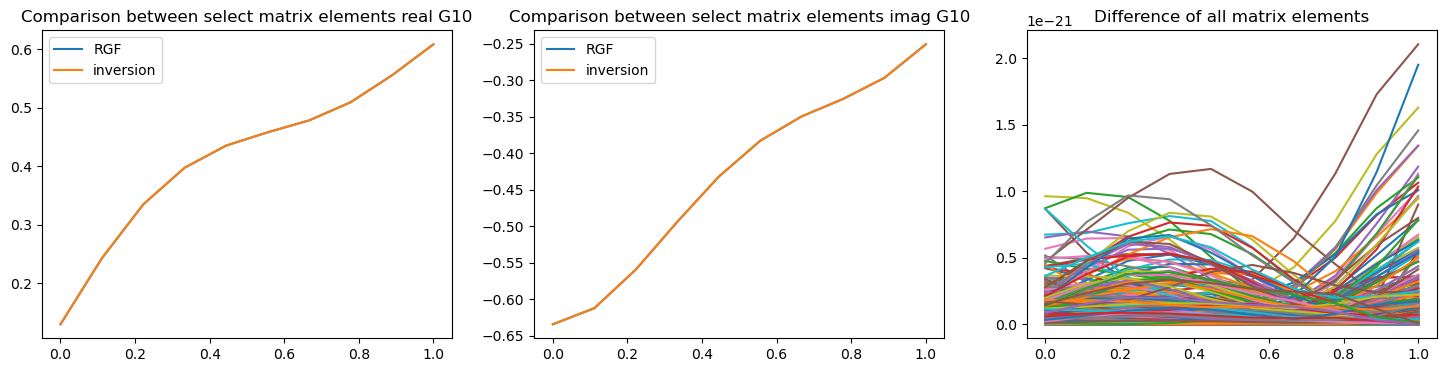

In [9]:

names = ["left surface", "right surface"]
for RGF, exact, name in zip([GL,GR],[g_surf_Lslice,g_surf_Rslice], names):
    
    dif = np.zeros([C,C,NE])
    for i in range(C):
        for j in range(C):
            dif[i,j,:] = abs(RGF[i,j,:] - exact[:,i,j])**2
    
    dE = energies[1] - energies[0]
    norm = dif.sum()*dE
    print("norm",norm*dE)

    print(name)
    fig, axs = plt.subplots(1,3,figsize=(18,4))
    i=1; j=0
    axs[0].set_title(f"Comparison between select matrix elements real G{i}{j}")
    axs[0].plot(energies,np.real(RGF[i,j,:]), label="RGF")
    axs[0].plot(energies,np.real(exact[:,i,j]), label="inversion")
    axs[0].legend()
    
    axs[1].set_title(f"Comparison between select matrix elements imag G{i}{j}")
    axs[1].plot(energies,np.imag(RGF[i,j,:]), label="RGF")
    axs[1].plot(energies,np.imag(exact[:,i,j]), label="inversion")
    axs[1].legend()
    
    for i in range(C):
        for j in range(C):
            p = np.real(dif[i,j,:])
            axs[2].plot(energies,p)
    axs[2].set_title("Difference of all matrix elements")
    
    plt.show()

## Testing the local Green's function $G_{nn}$ with drop

0.0 17.5


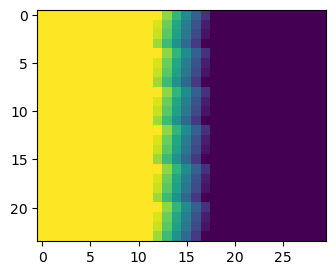

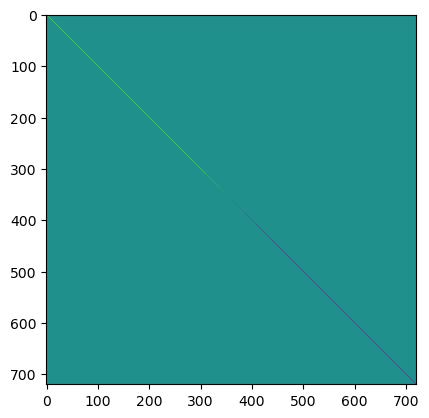

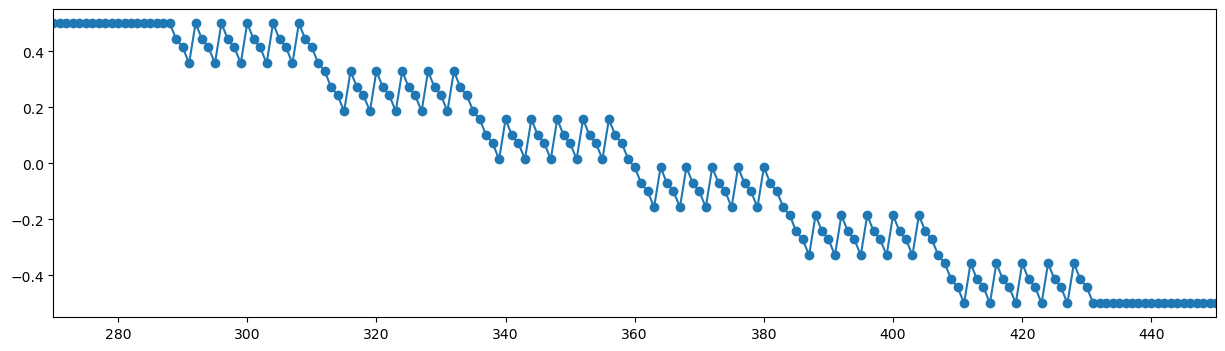

In [10]:
dV = 1.0

# find the smallest and largest positions inside the sample
xmin = np.min(gramag.X)
xmax = np.max(gramag.X)
size = xmax - xmin  # extent of the drop

print(xmin, xmax)

Xp = (gramag.X - xmin)/size

drop = np.zeros([NL, C])
drop[:L,:] = dV/2
drop[L+S:,:] = -dV/2
drop[L:L+S,:] = dV*(1.0-2*Xp)/2

fig, axs = plt.subplots(1,1,figsize=(10,3))
plt.imshow(drop.transpose())
plt.show()

# Drop matrix defined in the whole Hilbert space
dropmat = np.zeros([N,N], dtype=complex)
for i in range(NL):
    for j in range(width):
        for oo in range(No):
            m = j*No + oo
            n = i*C + m
            dropmat[n,n] = drop[i,m]

            
plt.imshow(np.real(dropmat))
plt.show()

fig, axs = plt.subplots(1,1,figsize=(15,4))
axs.plot(np.real(np.diag(dropmat)),'o-')
axs.set_xlim([270,450])
plt.show()


In [11]:
H = gramag.H0 + dropmat

green_inv    = np.zeros([NE,N,N], dtype=complex)

for ee,z in enumerate(zs):
    print(ee, end=" ")
    zn = np.conjugate(z)
    
    # Complete Green's function
    green_inv[ee,:,:]   = np.linalg.inv(np.eye(N)*z - H)
    
    

0 1 2 3 4 5 6 7 8 9 

In [12]:
# extract the correct slice from the green's function
n = 2
a = (n+L)*C
b = (n+1+L)*C
exact = green_inv[:,a:b,a:b]*1.0

RGF = gramag.get_Gnn_drop(zs,n,dV)*1.0

norm 4.4654055861602195e-21


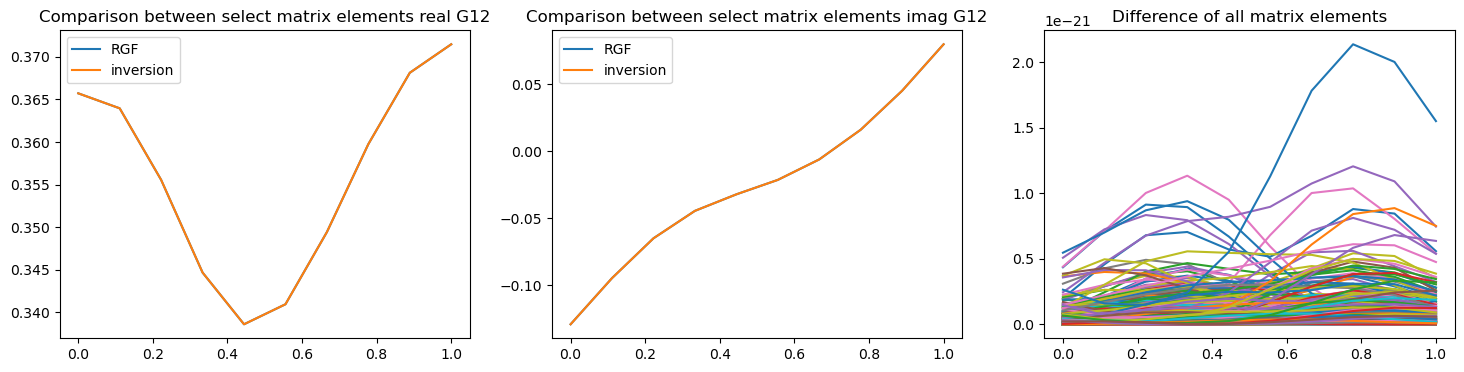

In [13]:

dif = np.zeros([C,C,NE])
for i in range(C):
    for j in range(C):
        dif[i,j,:] = abs(RGF[i,j,:] - exact[:,i,j])**2

dE = energies[1] - energies[0]
norm = dif.sum()*dE
print("norm",norm*dE)


fig, axs = plt.subplots(1,3,figsize=(18,4))
i=1; j=2
axs[0].set_title(f"Comparison between select matrix elements real G{i}{j}")
axs[0].plot(energies,np.real(RGF[i,j,:]), label="RGF")
axs[0].plot(energies,np.real(exact[:,i,j]), label="inversion")
axs[0].legend()

axs[1].set_title(f"Comparison between select matrix elements imag G{i}{j}")
axs[1].plot(energies,np.imag(RGF[i,j,:]), label="RGF")
axs[1].plot(energies,np.imag(exact[:,i,j]), label="inversion")
axs[1].legend()

for i in range(C):
    for j in range(C):
        p = np.real(dif[i,j,:])
        axs[2].plot(energies,p)
axs[2].set_title("Difference of all matrix elements")
plt.show()

## Testing the sample Green's function with drop

In [14]:
# extract the correct slice from the green's function

a = L*C
b = (S+L)*C
exact = green_inv[:,a:b,a:b]

RGF,mat = gramag.get_green_large_drop(zs,dV)

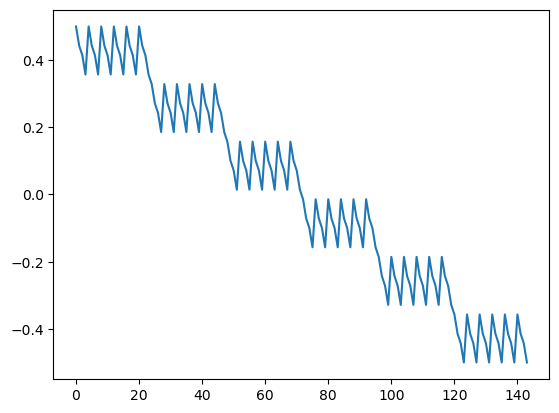

In [15]:
plt.plot(np.diag(np.real(mat)))

norm 3.885032446910731e-18


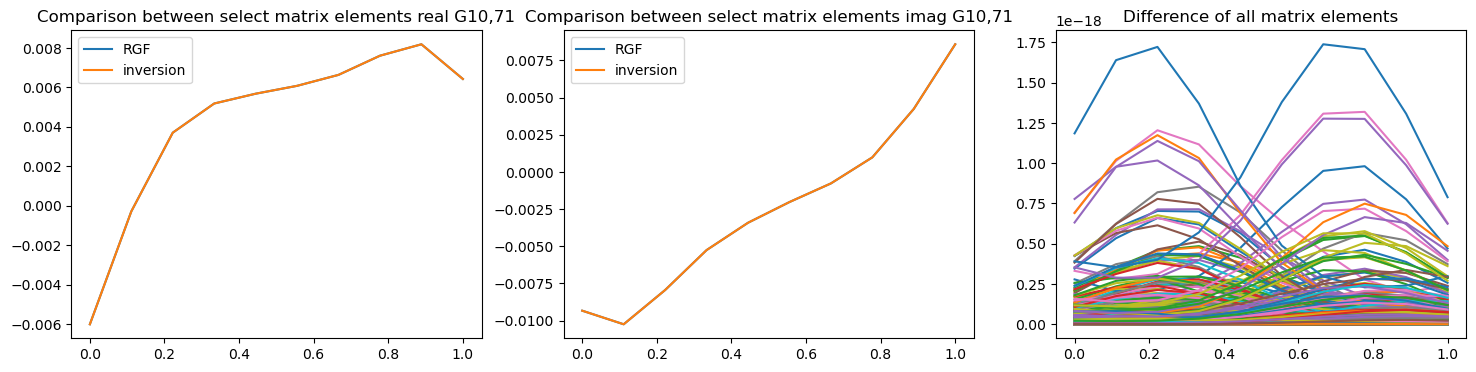

In [16]:

dif = np.zeros([C,C,NE])
for i in range(C):
    for j in range(C):
        dif[i,j,:] = abs(RGF[i,j,:] - exact[:,i,j])**2

dE = energies[1] - energies[0]
norm = dif.sum()*dE
print("norm",norm*dE)


fig, axs = plt.subplots(1,3,figsize=(18,4))
i=10; j=71
axs[0].set_title(f"Comparison between select matrix elements real G{i},{j}")
axs[0].plot(energies,np.real(RGF[i,j,:]), label="RGF")
axs[0].plot(energies,np.real(exact[:,i,j]), label="inversion")
axs[0].legend()

axs[1].set_title(f"Comparison between select matrix elements imag G{i},{j}")
axs[1].plot(energies,np.imag(RGF[i,j,:]), label="RGF")
axs[1].plot(energies,np.imag(exact[:,i,j]), label="inversion")
axs[1].legend()

for i in range(C):
    for j in range(C):
        p = np.real(dif[i,j,:])
        axs[2].plot(energies,p)
axs[2].set_title("Difference of all matrix elements")
plt.show()

## Testing the local Green's function $G_{nn}$

In [17]:
H = gramag.H0

green_inv    = np.zeros([NE,N,N], dtype=complex)

for ee,z in enumerate(zs):
    print(ee, end=" ")
    zn = np.conjugate(z)
    
    # Complete Green's function
    green_inv[ee,:,:]   = np.linalg.inv(np.eye(N)*z - H)
    
    

0 1 2 3 4 5 6 7 8 9 

In [18]:
# extract the correct slice from the green's function
a = (n+L)*C
b = (n+1+L)*C
exact = green_inv[:,a:b,a:b]

Gn = gramag.get_Gnn(zs,n)
RGF = Gn*1.0

norm 3.9433929031454294e-21


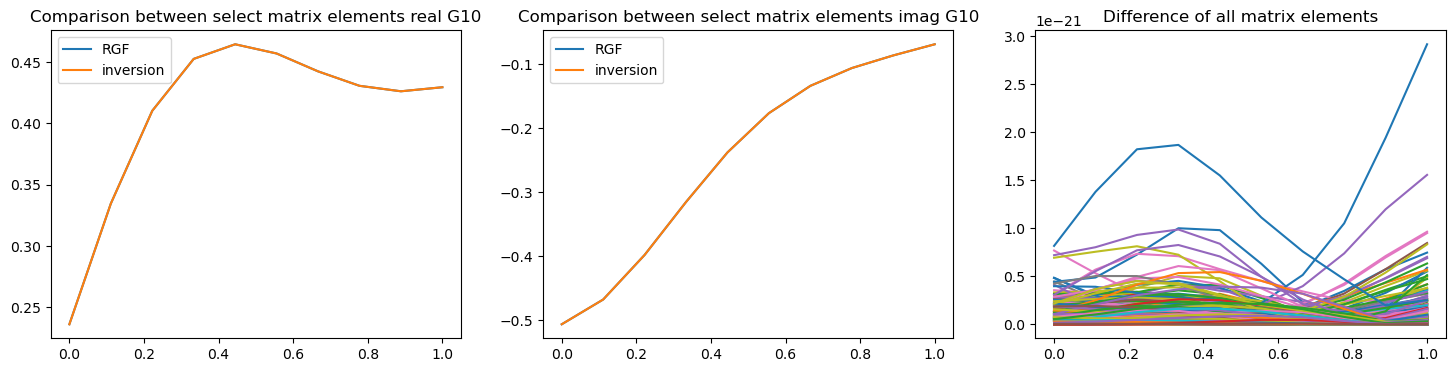

In [19]:


dif = np.zeros([C,C,NE])
for i in range(C):
    for j in range(C):
        dif[i,j,:] = abs(RGF[i,j,:] - exact[:,i,j])**2

dE = energies[1] - energies[0]
norm = dif.sum()*dE
print("norm",norm*dE)


fig, axs = plt.subplots(1,3,figsize=(18,4))
i=1; j=0
axs[0].set_title(f"Comparison between select matrix elements real G{i}{j}")
axs[0].plot(energies,np.real(RGF[i,j,:]), label="RGF")
axs[0].plot(energies,np.real(exact[:,i,j]), label="inversion")
axs[0].legend()

axs[1].set_title(f"Comparison between select matrix elements imag G{i}{j}")
axs[1].plot(energies,np.imag(RGF[i,j,:]), label="RGF")
axs[1].plot(energies,np.imag(exact[:,i,j]), label="inversion")
axs[1].legend()

for i in range(C):
    for j in range(C):
        p = np.real(dif[i,j,:])
        axs[2].plot(energies,p)
axs[2].set_title("Difference of all matrix elements")
plt.show()

## Testing $G_{0n} $

In [20]:
# list of complex energies
eta = 0.4
NE = 10
energies = np.linspace(0,1.0, NE)
zs = energies + eta*1j
print(zs)

[0.        +0.4j 0.11111111+0.4j 0.22222222+0.4j 0.33333333+0.4j
 0.44444444+0.4j 0.55555556+0.4j 0.66666667+0.4j 0.77777778+0.4j
 0.88888889+0.4j 1.        +0.4j]


In [21]:
H = gramag.H0
n = 2

green_inv    = np.zeros([NE,N,N], dtype=complex)

for ee,z in enumerate(zs):
    print(ee, end=" ")
    zn = np.conjugate(z)
    
    # Complete Green's function
    green_inv[ee,:,:]   = np.linalg.inv(np.eye(N)*z - H)
    
    

0 1 2 3 4 5 6 7 8 9 

In [22]:
G0n = gramag.get_G0n(zs, n)
RGF = G0n*1.0

i1 = C*(L-1)
i2 = C*(L)
j1 = C*(L+n)
j2 = C*(L+n+1)

exact = green_inv[:,i1:i2, j1:j2]

norm 6.173644144352538e-19


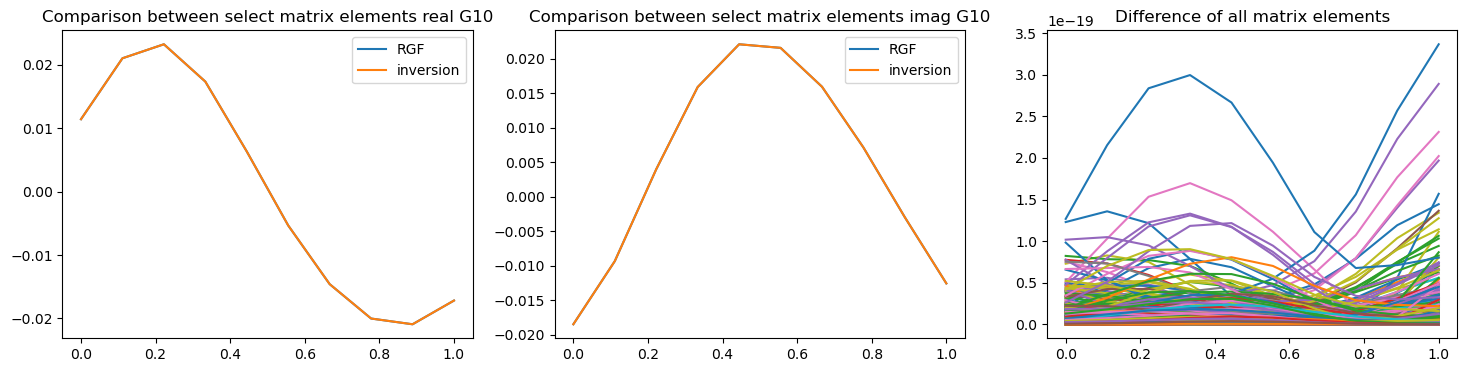

In [23]:

dif = np.zeros([C,C,NE])
for i in range(C):
    for j in range(C):
        dif[i,j,:] = abs(RGF[i,j,:] - exact[:,i,j])**2

dE = energies[1] - energies[0]
norm = dif.sum()*dE
print("norm",norm*dE)


fig, axs = plt.subplots(1,3,figsize=(18,4))
i=1; j=0
axs[0].set_title(f"Comparison between select matrix elements real G{i}{j}")
axs[0].plot(energies,np.real(RGF[i,j,:]), label="RGF")
axs[0].plot(energies,np.real(exact[:,i,j]), label="inversion")
axs[0].legend()

axs[1].set_title(f"Comparison between select matrix elements imag G{i}{j}")
axs[1].plot(energies,np.imag(RGF[i,j,:]), label="RGF")
axs[1].plot(energies,np.imag(exact[:,i,j]), label="inversion")
axs[1].legend()

for i in range(C):
    for j in range(C):
        p = np.real(dif[i,j,:])
        axs[2].plot(energies,p)
axs[2].set_title("Difference of all matrix elements")
plt.show()

## Testing $G_{0n}$ with drop

In [24]:
# not implemented yet

## Testing G_n,N+1

In [25]:
H = gramag.H0


green_inv    = np.zeros([NE,N,N], dtype=complex)

for ee,z in enumerate(zs):
    print(ee, end=" ")
    zn = np.conjugate(z)
    
    # Complete Green's function
    green_inv[ee,:,:]   = np.linalg.inv(np.eye(N)*z - H)
    
    

0 1 2 3 4 5 6 7 8 9 

In [26]:
n = 2

GnN = gramag.get_GnNp1(zs, n)
RGF = GnN*1.0

i1 = C*(L+n)
i2 = C*(L+n+1)
j1 = C*(L+S)
j2 = C*(L+S+1)


exact = green_inv[:,i1:i2, j1:j2]

norm 1.0626707252009825e-19


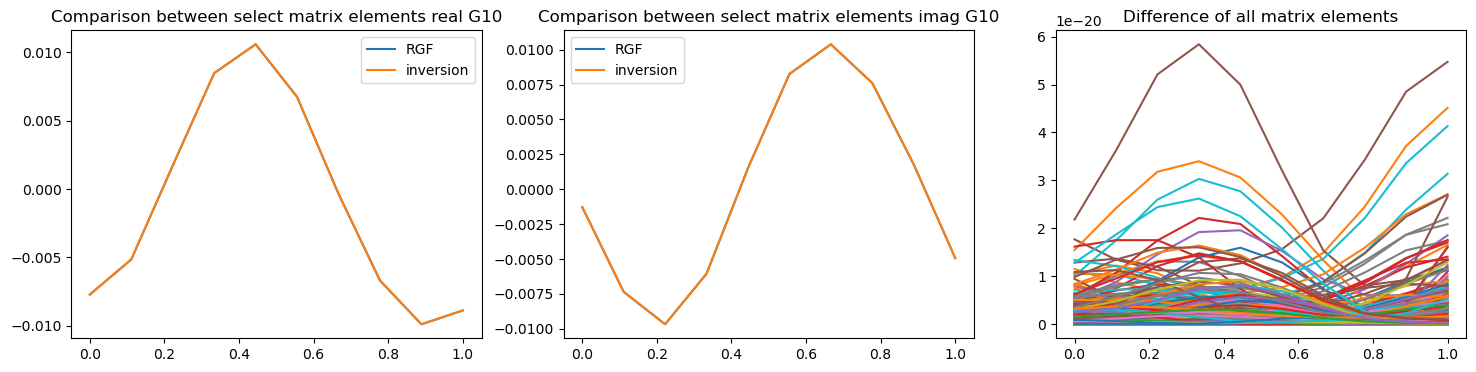

In [27]:

dif = np.zeros([C,C,NE])
for i in range(C):
    for j in range(C):
        dif[i,j,:] = abs(RGF[i,j,:] - exact[:,i,j])**2

dE = energies[1] - energies[0]
norm = dif.sum()*dE
print("norm",norm*dE)


fig, axs = plt.subplots(1,3,figsize=(18,4))
i=1; j=0
axs[0].set_title(f"Comparison between select matrix elements real G{i}{j}")
axs[0].plot(energies,np.real(RGF[i,j,:]), label="RGF")
axs[0].plot(energies,np.real(exact[:,i,j]), label="inversion")
axs[0].legend()

axs[1].set_title(f"Comparison between select matrix elements imag G{i}{j}")
axs[1].plot(energies,np.imag(RGF[i,j,:]), label="RGF")
axs[1].plot(energies,np.imag(exact[:,i,j]), label="inversion")
axs[1].legend()

for i in range(C):
    for j in range(C):
        p = np.real(dif[i,j,:])
        axs[2].plot(energies,p)
axs[2].set_title("Difference of all matrix elements")
plt.show()

## Testing $G_{nN}$ with drop

In [28]:
# not implemented

## Checking if $G^r_{0n}=G^a_{n0}$

In [29]:
print(N)
print(3*8*(12*2+6))
print(C)
print("L",L)

# list of complex energies
eta = 0.1
NE = 10
energies = np.linspace(0,1.0, NE)
zs = energies + eta*1j

720
720
24
L 12


In [30]:
H = gramag.H0


greenR_inv    = np.zeros([NE,N,N], dtype=complex)
greenA_inv    = np.zeros([NE,N,N], dtype=complex)

for ee,z in enumerate(zs):
    print(ee, end=" ")
    zn = np.conjugate(z)
    
    # Complete Green's function
    greenR_inv[ee,:,:]   = np.linalg.inv(np.eye(N)*z  - H)
    greenA_inv[ee,:,:]   = np.linalg.inv(np.eye(N)*zn - H)
    


0 1 2 3 4 5 6 7 8 9 

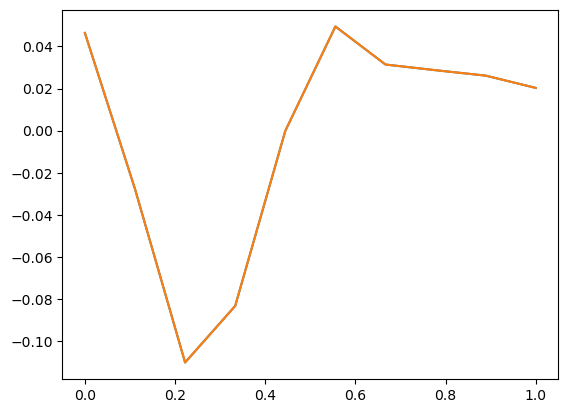

In [31]:
# G0n = gramag.get_G0n(zs, n)
# RGF = G0n*1.0
n = 2

# Get only the chunk between slice 0 and n
i1 = C*(L-1)
i2 = C*(L)
j1 = C*(L+n)
j2 = C*(L+n+1)

exactR = greenR_inv[:,i1:i2, j1:j2]
exactA = greenA_inv[:,j1:j2, i1:i2]

# for b in range(C):
a = 1
b = a+2
plt.plot(energies,  np.imag(exactR[:,a,b]))
plt.plot(energies, -np.imag(exactA[:,b,a]))
plt.show()

In [32]:
G0n_adv = gramag.get_G0n(zs,n)

## Testing the right and left complete sweep

In [33]:

# Testing the sweep from left to right
# e = C*(L+S)
# H_sweep_LR = H[0:e,0:e]*1.0

# e = C*L
# H_sweep_RL = H[e:,e:]*1.0


## Testing a second way to get the surface Green's function

In [34]:
n = 5

G = gramag.get_green_large(zs)
Gnn = gramag.get_Gnn(zs,n)

a = n*C
b = (n+1)*C
Gslice = G[a:b,a:b,:]

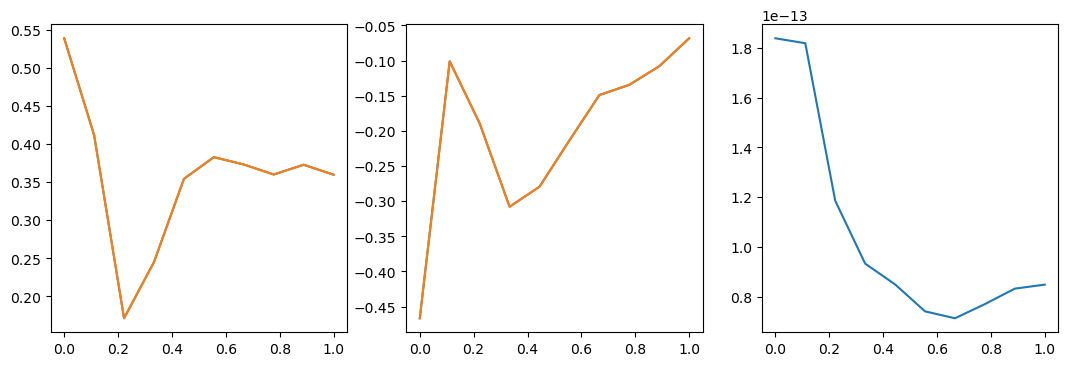

In [35]:
i=1; j=2
fig, axs = plt.subplots(1,3,figsize=(13,4))
axs[0].plot(energies, np.real(Gnn[i,j,:]))
axs[0].plot(energies, np.real(Gslice[i,j,:]))

axs[1].plot(energies, np.imag(Gnn[i,j,:]))
axs[1].plot(energies, np.imag(Gslice[i,j,:]))

dif = np.abs(Gnn - Gslice).sum(axis=0).sum(axis=0)
axs[2].plot(energies, dif)
plt.show()

## More thorough test

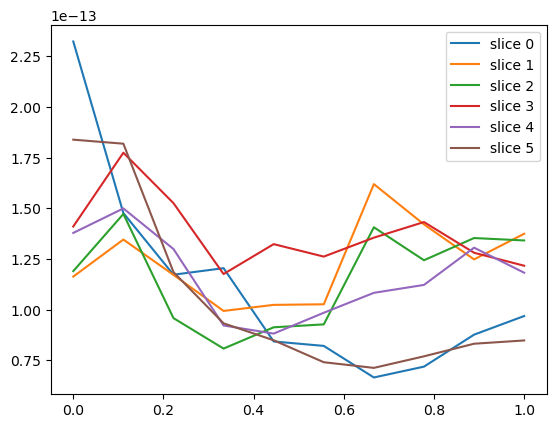

In [36]:
G = gramag.get_green_large(zs)
dif = np.zeros([NE,length])
for n in range(length):
    Gnn = gramag.get_Gnn(zs,n)
    a = n*C
    b = (n+1)*C
    Gslice = G[a:b,a:b,:]
    
    dif[:,n] = np.abs(Gnn - Gslice).sum(axis=0).sum(axis=0)
    
for n in range(length):
    plt.plot(energies, dif[:,n], label=f"slice {n}")
plt.legend()
plt.show()

# Testing convergence

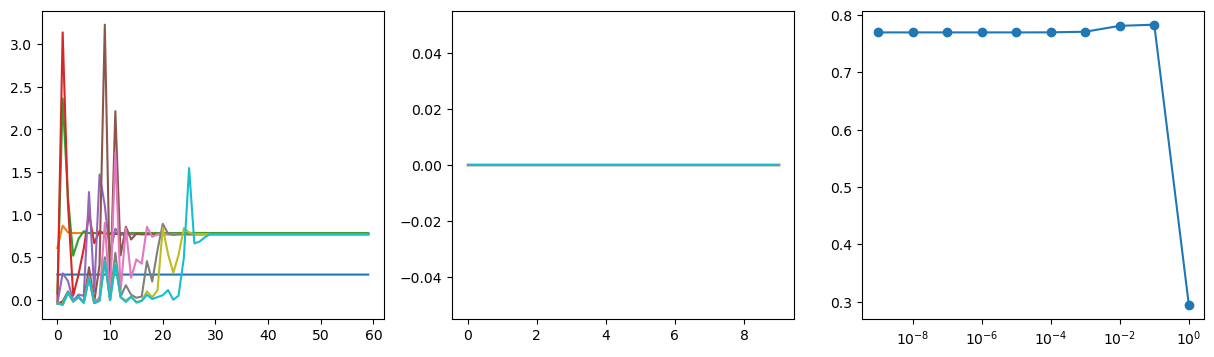

In [37]:
etas = np.array([0.1**i for i in range(10)])
Netas = len(etas)
niter = 60
convs = np.zeros([Netas, niter])

for j, eta in enumerate(etas):
    z = 1.8 + eta*1j
    
    conv = gramag.build_surface_green_right(z, niter=niter)*1.0
    # conv1 = np.abs(conv).sum(axis=0).sum(axis=0)
    conv1 = np.imag(conv[0,1,:])
    convs[j,:] = conv1
    
fig, axs = plt.subplots(1,3,figsize=(15,4))
for i in range(Netas):
    axs[0].plot(convs[i,:])
    axs[1].plot(convs[i,-10:] - convs[i,-1])

axs[2].plot(etas, convs[:,-1],'o-')
axs[2].set_xscale('log')
plt.show()

# Testing Ozaki - convergence with number of poles

In [38]:
width=2
length=4
twist = False
k = 0
lead = 12


# set the relevant quantities
gramag = rgf.rgf()
gramag.set_graphene_nanoribbon_rashba(width, length, twist, k, ander=1.0)


C = gramag.C
S = gramag.S
No = gramag.No



# Anderson = np.zeros([C,S])
# Anderson[2,2] = 10
ander = 1
Anderson = np.random.random([C,S])*ander
gramag.Anderson = Anderson

    
dV = 0.01
gramag.build_spin()
gramag.build_vels_hsample()
gramag.generate_hamiltonian(lead, lead)
gramag.hamiltonian_add_drop(dV)
# gramag.get_eigs() # for testing purposes. assumes drop is defined

NL = gramag.NL
N = gramag.N
L = lead
R = lead



# list of complex energies
eta = 0.3
NE = 10
energies = np.linspace(0,1.0, NE)
zs = energies + eta*1j


0.0 11.5


In [39]:
slice_n = 2
n = 2 # slice
a = C*n
b = a+C

vx = gramag.vx[a:b,a:b]
vy = gramag.vy[a:b,a:b]
sx = gramag.spinx[a:b,a:b]
sy = gramag.spiny[a:b,a:b]

# Operator in the slice
op_local = np.zeros([C,C], dtype=complex)
op_local = sx*1.0

In [40]:
## Convergência com numero de polos

Nozes     = [20, 30, 40,60, 80,100, 160, 200, 300]; NNozes = len(Nozes)
betas     = [100,200,400,800, 1600, 3000];          Nbetas = len(betas)
etas      = [1e-1, 1e-2, 1e-4, 1e-6];               Netas  = len(etas)
mu_points = np.array([0.3, 1.0]);                   Nmus   = len(mu_points)

seas = np.zeros([NNozes, Nbetas, Netas, Nmus], dtype=complex)

for nn,Noz in enumerate(Nozes):
    print("________ Number of Ozaki poles (Noz):", Noz)
    for bb, beta in enumerate(betas):
        print("Temperature beta:", beta)
        for ee, eta in enumerate(etas):
            print("Broadening eta:", eta)
        
            sea  = gramag.keldysh_sea_drop(mu_points, slice_n, op_local, dV, eta, beta=beta, Nozaki = Noz)
            print("")
            seas[nn,bb,ee,:] = sea
    
    
    

________ Number of Ozaki poles (Noz): 20
Temperature beta: 100
Broadening eta: 0.1
mu 0.30mu 1.00
Broadening eta: 0.01
mu 0.30mu 1.00
Broadening eta: 0.0001
mu 0.30mu 1.00
Broadening eta: 1e-06
mu 0.30mu 1.00
Temperature beta: 200
Broadening eta: 0.1
mu 0.30mu 1.00
Broadening eta: 0.01
mu 0.30mu 1.00
Broadening eta: 0.0001
mu 0.30mu 1.00
Broadening eta: 1e-06
mu 0.30mu 1.00
Temperature beta: 400
Broadening eta: 0.1
mu 0.30mu 1.00
Broadening eta: 0.01
mu 0.30mu 1.00
Broadening eta: 0.0001
mu 0.30mu 1.00
Broadening eta: 1e-06
mu 0.30mu 1.00
Temperature beta: 800
Broadening eta: 0.1
mu 0.30mu 1.00
Broadening eta: 0.01
mu 0.30mu 1.00
Broadening eta: 0.0001
mu 0.30mu 1.00
Broadening eta: 1e-06
mu 0.30mu 1.00
Temperature beta: 1600
Broadening eta: 0.1
mu 0.30mu 1.00
Broadening eta: 0.01
mu 0.30mu 1.00
Broadening eta: 0.0001
mu 0.30mu 1.00
Broadening eta: 1e-06
mu 0.30mu 1.00
Temperature beta: 3000
Broadening eta: 0.1
mu 0.30mu 1.00
Broadening eta: 0.01
mu 0.30mu 1.00
Broadening eta: 0.0001
m

KeyboardInterrupt: 

In [ ]:
mm = 1
fig, axs = plt.subplots(Netas,2,figsize=(15,15),sharex=True)
for ee,eta in enumerate(etas):
    
    for bb,beta in enumerate(betas):
        if bb < 2:
            continue
        ys = seas[:,bb,ee,mm]
        axs[ee,0].plot(Nozes, np.real(ys), 'o-', label=f"{beta=}")
        axs[ee,1].plot(Nozes, np.imag(ys), 'o-', label=f"{beta=}")
        

    axs[ee,0].set_title(f"Real part $\eta$={eta}", fontsize=20)
    axs[ee,1].set_title(f"Imag part $\eta$={eta}", fontsize=20)
    axs[0,0].legend()
    for i in range(2):
        axs[-1,i].set_xlabel("Number of Ozaki poles", fontsize=14)


plt.show()


In [ ]:
mm = 0
fig, axs = plt.subplots(1,2,figsize=(15,5),sharex=True)
for ee,eta in enumerate(etas):
    
    ys = seas[-1,:,ee,mm]
    axs[0].plot(betas, np.abs(np.real(ys)), 'o-', label=f"{eta=}")
    axs[1].plot(betas, np.abs(np.imag(ys)), 'o-', label=f"{eta=}")


    # axs[ee,0].set_title(f"Real part $\eta$={eta}", fontsize=20)
    # axs[ee,1].set_title(f"Imag part $\eta$={eta}", fontsize=20)
    axs[0].legend()
    for i in range(2):
        axs[i].set_xlabel("Number of Ozaki poles", fontsize=14)
        axs[i].set_yscale('log')


plt.show()


## Compare ozaki vs finite Green

In [ ]:
# def get_ozaki(N):

#     B = np.zeros([N,N])
#     for i in range(N-1):
#         n = i+1
#         b = 0.5/np.sqrt((2*n+1)*(2*n-1))
#         B[i,i+1] = b
#         B[i+1,i] = b

#     vals, vecs = np.linalg.eigh(B)

#     # Select the ones that are larger than zero
#     assert(N%2==0)
#     poles = []
#     residues = []
#     for i in range(N):
#         if vals[i] > 0:
#             pole = 1/vals[i]
#             res = -abs(vecs[:,i][0])**2/4*pole**2
#             poles.append(pole)
#             residues.append(res)
    
#     return poles, residues


# def ozaki_integrator(f,N=200, tol=1e-6):
#     # Does not include the first term
    
#     # Not repeating the ozaki calculation
#     if N not in ozaks:
#         poles, residues = get_ozaki(N)
#         ozaks[N] = [poles, residues]
#     else:
#         poles, residues = ozaks[N]
    
    
#     terms = []
#     for i in range(N//2):

#         pole = poles[i]*1j
#         res = residues[i]

#         # Evaluate the trace at the pole
#         term = f(pole)*np.pi*2j*res
#         terms.append(term)
        
#         # print(term, pole, res)
                
            
#     return np.sum(terms)


# def keldysh_sea_drop(self, mus, n, op, dV, eta, beta = 200, Nozaki=400):
#     # Integrate the Fermi Sea term with Ozaki
        

#     # Function to put inside Ozaki integrator
#     def f(mu,x):
#         z = x/beta + mu + 1j*eta
#         zarr = np.array([z])
#         Gnn = self.get_Gnn_drop(zarr,n, dV)
#         green = Gnn[:,:,0]
#         tt = np.trace(green@op)
#         return tt/beta
    
    
#     NE = len(mus)
#     tr = np.zeros(NE, dtype=complex)
#     for mm,mu in enumerate(mus):
#         print(f"mu {mu:2.2f}",end="")
        
#         def fL(x): return f( dV/2 + mu,x)
#         def fR(x): return f(-dV/2 + mu,x)
        
#         somaL = ozaki_integrator(fL,N=Nozaki)
#         somaL += -np.pi*1j/2*np.trace(op)

#         somaR = ozaki_integrator(fR,N=Nozaki)
#         somaR += -np.pi*1j/2*np.trace(op)
        
        
#         tr[mm] = somaL + somaR

#     return tr

In [ ]:



NE = 4
lim = 4
mus = np.linspace(-lim, lim,NE)
sea  = gramag.keldysh_sea_drop(mus, n, op_local, dV, eta)
sea0 = gramag.keldysh_sea_drop(mus, n, op_local, dV*0, eta)



In [ ]:
plt.plot(mus, np.imag(sea-sea0)/dV)
plt.show()

plt.plot(mus, np.imag(sea)/dV)
plt.plot(mus, np.imag(sea0)/dV)
plt.show()

In [ ]:
gramag.get_eigs() # for testing purposes. assumes drop is defined

In [ ]:
# Operator defined inside of the sample, in terms of the operator defined in the slice
op_sample = np.zeros([C*S, C*S], dtype=complex)
a = C*slice_n
b = a+C
op_sample[a:b,a:b] = op_local

# Operator defined in the whole system, in terms of the operator defined in the sample
operator = np.zeros([N,N], dtype=complex)
a = C*L
b = a + S*C
operator[a:b,a:b] = op_sample*1.0

# operator in the energy basis - only needs to be calculated once
op_based  = gramag.Pt@operator@gramag.P
op_based0 = gramag.Pt0@operator@gramag.P0

# calculate the trace for all values of mu
traced  = np.zeros(NE, dtype=complex)
traced0 = np.zeros(NE, dtype=complex)
for i, mu in enumerate(mus):
    print(i, end="")
    muL = mu + dV/2
    muR = mu - dV/2
    
    # analytical result for the integral
    atanL = np.arctan((muL - gramag.vals )/eta) + np.pi/2
    atanR = np.arctan((muR - gramag.vals )/eta) + np.pi/2
    atan  = np.arctan((mu  - gramag.vals0)/eta) + np.pi/2
    
    # perform the trace
    traced[i]  += np.sum((atanL + atanR)*np.diag(op_based)/1j)
    traced0[i] += np.sum((      2*atan )*np.diag(op_based0)/1j)


In [ ]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

axs[0].plot(mus, np.imag(traced))
axs[0].plot(mus, np.imag(sea))
# axs[0].plot(mus, np.imag(traced-sea))


axs[1].plot(mus, np.imag(traced0))
axs[1].plot(mus, np.imag(sea0))
# axs[1].plot(mus, np.imag(traced0-sea0))

axs[2].plot(mus, np.imag(traced-traced0))
axs[2].plot(mus, np.imag(sea-sea0))

plt.show()

In [ ]:
# curves seem identical, but we have to check
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(mus, np.imag(traced-sea))
axs[1].plot(mus, np.imag(traced0-sea0))

plt.show()

# Test Kubo Sea term
Before checking if the integral is well calculated, first let's check the integrand

In [ ]:
width=2
length=4
twist = False
k = 0
lead = 12


# set the relevant quantities
gramag = rgf.rgf()
gramag.set_graphene_nanoribbon_rashba(width, length, twist, k, ander=1.0)


C = gramag.C
S = gramag.S
No = gramag.No



# Anderson = np.zeros([C,S])
# Anderson[2,2] = 10
ander = 1
Anderson = np.random.random([C,S])*ander
gramag.Anderson = Anderson

    
dV = 0.01
gramag.build_spin()
gramag.build_vels_hsample()
gramag.generate_hamiltonian(lead, lead)
gramag.hamiltonian_add_drop(dV)
gramag.get_eigs() # for testing purposes. assumes drop is defined

NL = gramag.NL
N = gramag.N
L = lead
R = lead



In [ ]:
# Take care of the operators

slice_n = 2
n = 2 # slice
a = C*slice_n
b = a+C
print(a,b)

# possible operators
vx = gramag.vx[a:b,a:b]
vy = gramag.vy[a:b,a:b]
sx = gramag.spinx[a:b,a:b]
sy = gramag.spiny[a:b,a:b]

# Operator in the slice
op_local = sx*1.0

# Operator defined inside of the sample, in terms of the operator defined in the slice
op_sample = np.zeros([C*S, C*S], dtype=complex)
a = C*slice_n
b = a+C
op_sample[a:b,a:b] = op_local

# Operator defined in the whole system, in terms of the operator defined in the sample
operator = np.zeros([N,N], dtype=complex)
a = C*L
b = a + S*C
operator[a:b,a:b] = op_sample*1.0

# velocity defined in the whole system, in terms of the operator defined in the sample
vx_finite = np.zeros([N,N], dtype=complex)
a = C*L
b = a + S*C
vx_finite[a:b,a:b] = gramag.vx*1.0

# Change the basis of these operator into the energy basis
op_en = gramag.Pt0@operator@gramag.P0
vx_en = gramag.Pt0@vx_finite@gramag.P0
op_KS = vx_en*op_en.transpose()

In [ ]:
# list of complex energies
eta = 0.5
NE = 30
lim = 4.0
energies = np.linspace(-lim, lim+2, NE)
zs = energies + eta*1j

# Using RGF with numerical derivative. Checking if it's allowed to use symmetries
de = 1e-6
kubo_sea_rgf2 = gramag.kubo_sea2(zs, op_sample, de)
kubo_sea_rgf  = gramag.kubo_sea(zs, op_sample, de)
kubo_sea_rgf3  = -np.conjugate(gramag.kubo_sea_old(zs, op_sample, de))

# Represent the data
names = ["with symmetries", "without symms", "-old*"]
fig, axs = plt.subplots(1,2,figsize=(12,5))
for kub,name in zip([kubo_sea_rgf,kubo_sea_rgf2,kubo_sea_rgf3], names):
    axs[0].plot(energies, np.real(kub), label=name)
    axs[1].plot(energies, np.imag(kub), label=name) 
    
titles = ["Real part", "Imaginary part"]
for i,title in enumerate(titles):
    axs[i].legend(fontsize=12)
    axs[i].set_title(title, fontsize=15)
    
plt.show()

In [ ]:
# Get the integrand of the Kubo Sea formula using exact diagonalization
integrand = np.zeros(NE, dtype=complex)

for i, z in enumerate(zs):
    print(i,end=" ")
    zc = np.conjugate(z)

    soma = 0
    for n in range(N):
        en = gramag.vals0[n]
        for m in range(N):
            em = gramag.vals0[m]
            
            g1 = 1.0/(z  - em)
            g2 = 1.0/(zc - em)
            g3 = 1.0/(z  - en)**2
            g4 = 1.0/(zc - en)**2
            
            g = (g1 - g2)*(g3 + g4)
            
            soma += g*op_KS[n,m]
    integrand[i] = -soma

In [ ]:

fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].plot(energies, np.real(kubo_sea_rgf), label="Kubo sea integrand RGF")
axs[0].plot(energies, np.real(integrand), label="Exact")
axs[1].plot(energies, np.imag(kubo_sea_rgf), label="Kubo sea integrand RGF")
axs[1].plot(energies, np.imag(integrand), label="Exact")
 
titles = ["Real part", "Imaginary part"]
for i,title in enumerate(titles):
    axs[i].legend(fontsize=12)
    axs[i].set_title(title, fontsize=15)
    
plt.show()

# Parallel ozaki integrator

In [ ]:

def ozaki_integrator2(self, f,N=200):
    # Does not include the first term
   
    # Not repeating the ozaki calculation
    if N not in self.ozaks:
        poles, residues = get_ozaki(N)
        self.ozaks[N] = [poles, residues]
    else:
        poles, residues = self.ozaks[N]
    
    
    terms = []
    for i in range(N//2):

        pole = poles[i]*1j
        res = residues[i]

        # Evaluate the trace at the pole
        term = f(pole)*np.pi*2j*res
        terms.append(term)
        
        # print(term, pole, res)
                
            
    return np.sum(terms)

def kubozaki_streda2(self, mus, op, de, beta = 600, Nozaki=400):
    # Integrate the kubo Sea term with Ozaki
        
    # Function to put inside Ozaki integrator
    def f(mu,x):
        z = x/beta + mu
        zarr = np.array([z])
        tt = self.kubo_streda_II(zarr, op,de)
        
        return tt/beta
    
    NE = len(mus)
    tr = np.zeros(NE, dtype=complex)
    for mm,mu in enumerate(mus):
        print(f"mu {mu:2.2f}",end="")
        
        def f1(x): return f(mu,x)
        
        soma1 = ozaki_integrator2(self,f1,N=Nozaki)
        tr[mm] = soma1

    return tr

In [ ]:
width=2
length=4
twist = False
k = 0
lead = 12


# set the relevant quantities
gramag = rgf.rgf()
gramag.set_graphene_nanoribbon_rashba(width, length, twist, k, ander=1.0)


C = gramag.C
S = gramag.S
No = gramag.No



# Anderson = np.zeros([C,S])
# Anderson[2,2] = 10
ander = 1
Anderson = np.random.random([C,S])*ander
gramag.Anderson = Anderson

    
dV = 0.01
gramag.build_spin()
gramag.build_vels_hsample()
gramag.generate_hamiltonian(lead, lead)
gramag.hamiltonian_add_drop(dV)
gramag.get_eigs() # for testing purposes. assumes drop is defined

NL = gramag.NL
N = gramag.N
L = lead
R = lead



In [ ]:
# Take care of the operators

slice_n = 2
n = 2 # slice
a = C*slice_n
b = a+C
print(a,b)

# possible operators
vx = gramag.vx[a:b,a:b]
vy = gramag.vy[a:b,a:b]
sx = gramag.spinx[a:b,a:b]
sy = gramag.spiny[a:b,a:b]

# Operator in the slice
op_local = sx*1.0

# Operator defined inside of the sample, in terms of the operator defined in the slice
op_sample = np.zeros([C*S, C*S], dtype=complex)
a = C*slice_n
b = a+C
op_sample[a:b,a:b] = op_local

In [ ]:
# list of complex energies
eta = 1e-4
NE = 4
lim = 4.0
de = 1e-5
energies = np.linspace(-lim, lim+2, NE)
zs = energies + eta*1j


In [ ]:
ks1 = gramag.kubozaki_streda(  zs, op_sample, de, Nozaki=40, beta=100)
ks2 = kubozaki_streda2(gramag, zs, op_sample, de, Nozaki=40, beta=100)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(energies, np.real(ks1))
axs[0].plot(energies, np.real(ks2))
axs[1].plot(energies, np.imag(ks1))
axs[1].plot(energies, np.imag(ks2))

# Testing Model - Rashba

In [8]:
width=4
length=3
twist = True
k = 0

lR = 0.3
R = lR*2.0j/3.0

# set the relevant quantities
gramag = rgf.rgf()
gramag.set_graphene_nanoribbon_rashba(width, length, twist, k, ander=0.0, m=0)

C  = gramag.C
S  = gramag.S
No = gramag.No

# ander = 1
# Anderson = np.random.random([C,S])*ander
# gramag.Anderson = Anderson

    

gramag.build_spin()
gramag.build_vels_hsample()


# NL = gramag.NL
# N = gramag.N
# L = lead
# R = lead



# list of complex energies
eta = 0.03
NE = 50
energies = np.linspace(-3.1,3.1, NE)
zs = energies + eta*1j


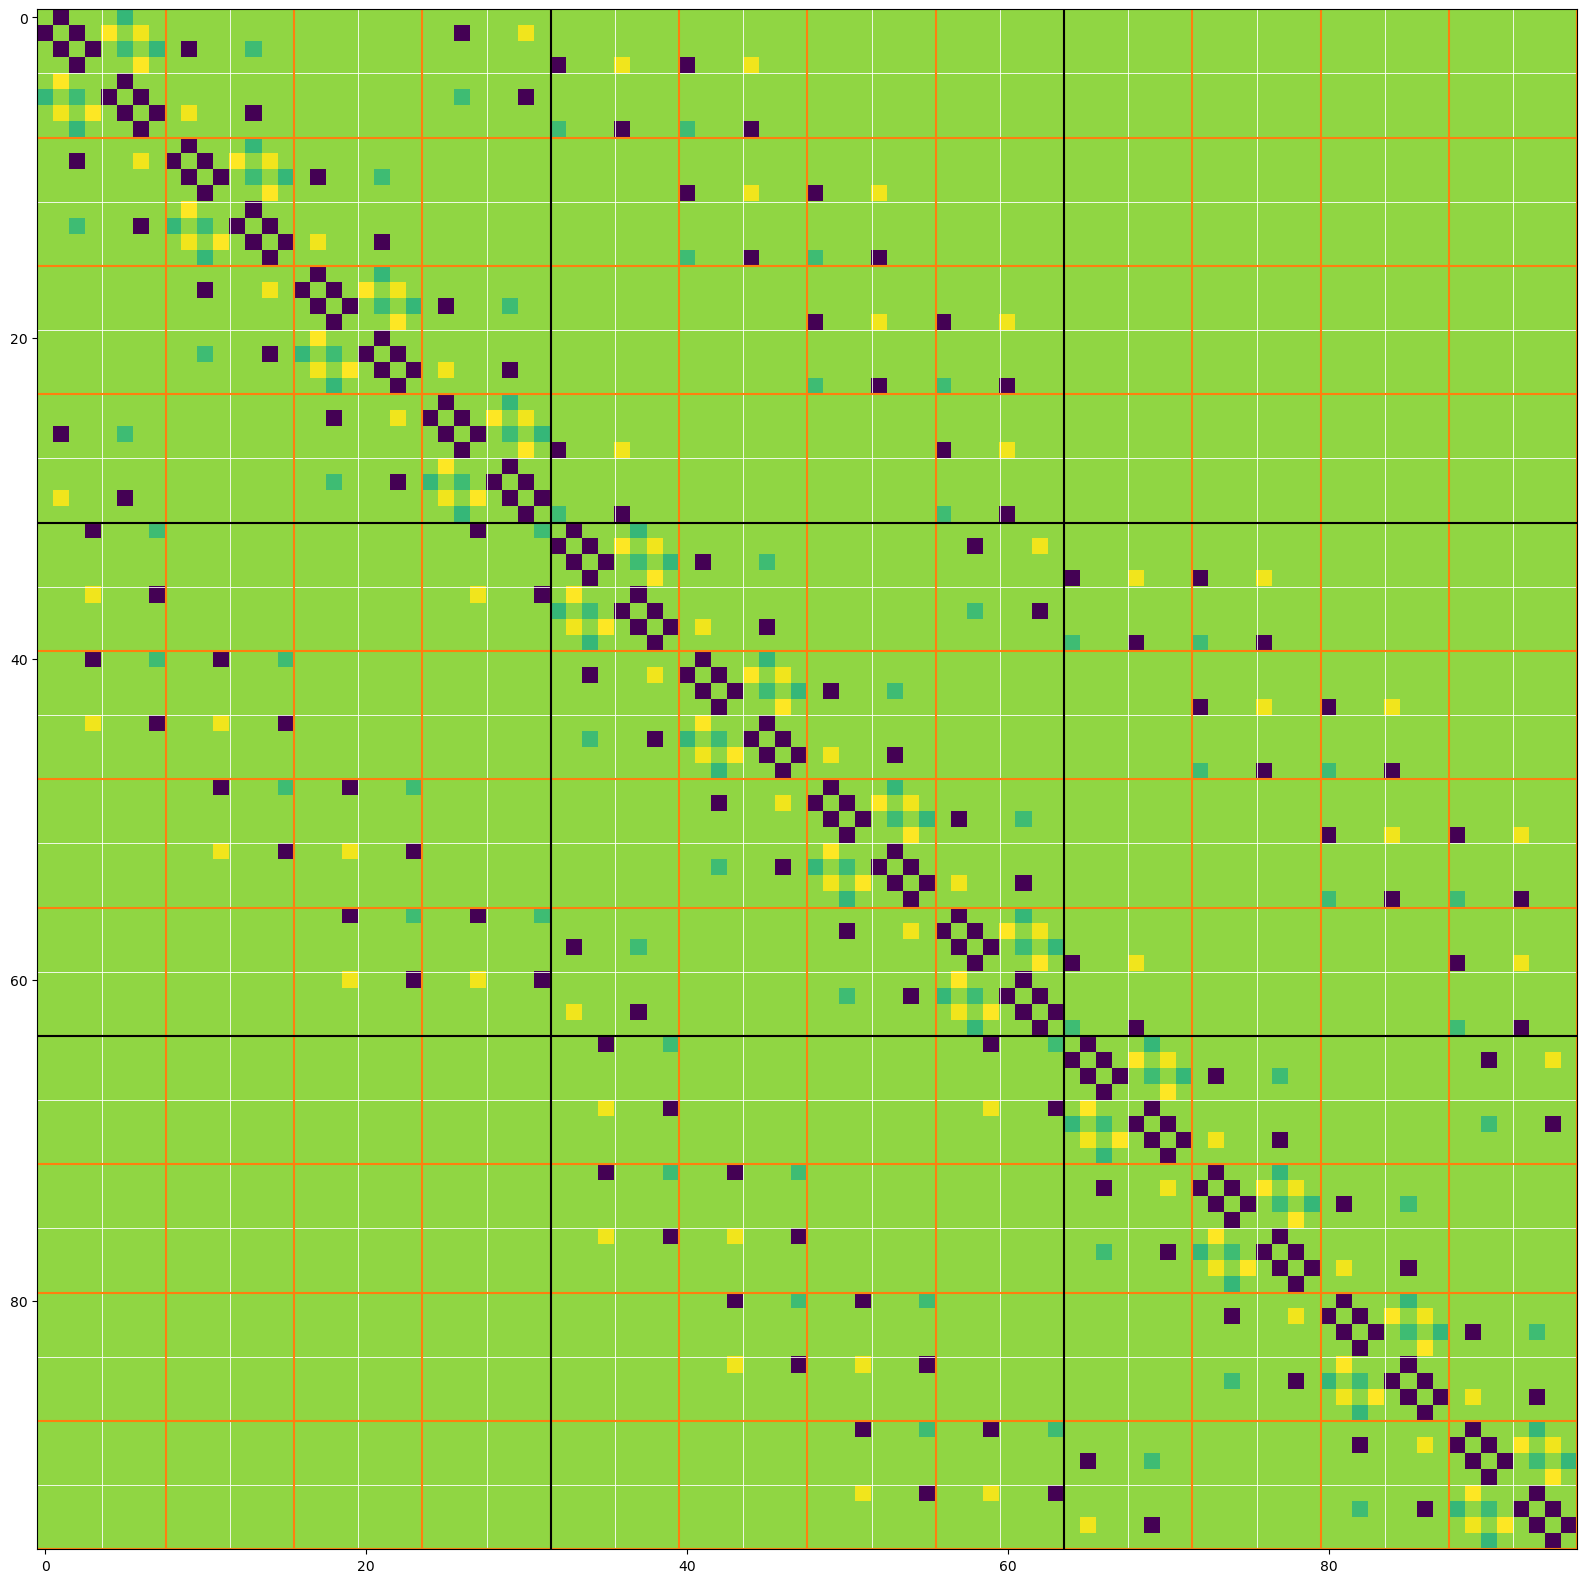

In [9]:
fig, axs = plt.subplots(1,1,figsize=(20,20))
axs.imshow(np.real(gramag.H_sample))

for i in range(1,25):
    axs.axvline(4*i-0.5, color='w', linewidth=0.6)
    axs.axhline(4*i-0.5, color='w', linewidth=0.6)

for i in range(1,13):
    axs.axvline(8*i-0.5, color='C1')
    axs.axhline(8*i-0.5, color='C1')

for i in range(1,3):
    axs.axvline(32*i-0.5, color='k')
    axs.axhline(32*i-0.5, color='k')
plt.show()

In [10]:
n = 2
mat = gramag.get_Gnn(zs, n)

In [11]:
dos = zs*0.0
for i in range(C):
    dos += mat[i,i]

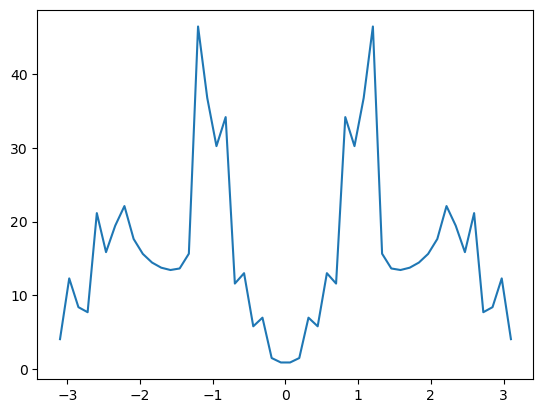

In [12]:
dos = -np.imag(dos)
plt.plot(energies, dos)
plt.show()

In [43]:
GR = bs.band_structure()
GR.DEBUG = 0 # Debug flag. Set to 1 to get debug information


# Information about the orbitals
orbitals = ["Au", "Bu", "Cu", "Du", "Ad", "Bd", "Cd", "Dd"]
orb_pos = [] # has to be in units of the primitive vector
for pos in gramag.pos:
    new_pos = pos*1.0
    new_pos[0] /= 3.0
    new_pos[1] /= np.sqrt(3)
    orb_pos.append(new_pos)


GR.set_orbs(orbitals, orb_pos)
GR.set_primitive2(gramag.prim[0], gramag.prim[1])

# Information about the hoppings for the tight-binding model
bonds = []
t = -1.0
sq = np.sqrt(3.0)/2.0
    
# Rashba hoppings: R = lR*2.0j/3.0
hop1 =      + 1j    # Au -> Bd same cell
hop2 =      - 1j    # Ad -> Bu same cell
hop3 =  0.5 + 1j*sq # Au -> Bd going to up left
hop4 =  0.5 - 1j*sq # Ad -> Bu going to up left
hop5 = -0.5 + 1j*sq # Au -> Bd going to down left
hop6 = -0.5 - 1j*sq # Ad -> Bu going to down left

hop1 *= R; hop2 *= R; hop3 *= R
hop4 *= R; hop5 *= R; hop6 *= R

# Spin up
bonds.append([[ 0, 0], 'Au', 'Bu', t])
bonds.append([[ 0, 0], 'Bu', 'Cu', t])
bonds.append([[ 0, 0], 'Cu', 'Du', t])
bonds.append([[ 1, 0], 'Du', 'Au', t])
bonds.append([[ 0, 1], 'Cu', 'Bu', t])
bonds.append([[ 1, 1], 'Du', 'Au', t])

# Spin down
bonds.append([[ 0, 0], 'Ad', 'Bd', t])
bonds.append([[ 0, 0], 'Bd', 'Cd', t])
bonds.append([[ 0, 0], 'Cd', 'Dd', t])
bonds.append([[ 1, 0], 'Dd', 'Ad', t])
bonds.append([[ 0, 1], 'Cd', 'Bd', t])
bonds.append([[ 1, 1], 'Dd', 'Ad', t])

# Rashba same unit cell
bonds.append([[ 0, 0], 'Au', 'Bd', hop1])
bonds.append([[ 0, 0], 'Cu', 'Dd', hop1])
bonds.append([[ 0, 0], 'Ad', 'Bu', hop2])
bonds.append([[ 0, 0], 'Cd', 'Du', hop2])
bonds.append([[ 0, 0], 'Cu', 'Bd', hop5]) #########
bonds.append([[ 0, 0], 'Cd', 'Bu', hop6]) #________

# Rashba connecting vertically
bonds.append([[ 0, 1], 'Cu', 'Bd', hop3]) #oooooooo
bonds.append([[ 0, 1], 'Cd', 'Bu', hop4])

# Rashbha connecting horizontally
bonds.append([[ 1, 0], 'Du', 'Ad', hop4.conjugate()]) 
bonds.append([[ 1, 0], 'Dd', 'Au', hop3.conjugate()]) #oooooooo

# Rashba connecting diagonally
bonds.append([[ 1, 1], 'Du', 'Ad', hop6.conjugate()]) #________
bonds.append([[ 1, 1], 'Dd', 'Au', hop5.conjugate()]) #########

GR.set_bonds(bonds)

In [14]:
# b1 = np.array([1.0, 0.0])
# b2 = np.array([0.0,   1.0/np.sqrt(3)])

all_vals = []
NKX = 300; dkx = 1/NKX
NKY = 4;   dky = 1/NKY
kx_list = np.array([i*dkx for i in range(NKX)])
ky_list = np.array([i*dky for i in range(NKY)])

for i,kx in enumerate(kx_list):
    for j,ky in enumerate(ky_list):
        k = np.array([kx,ky])
        Hk = GR.get_Hk(k)
        vals = np.linalg.eigvalsh(Hk)
        for val in vals:
            all_vals.append(val)

NK = NKX*NKY

In [15]:
dosk = zs*0.0
for val in all_vals:
    dosk += 1.0/(zs-val)
dosk = np.imag(dosk)/NK

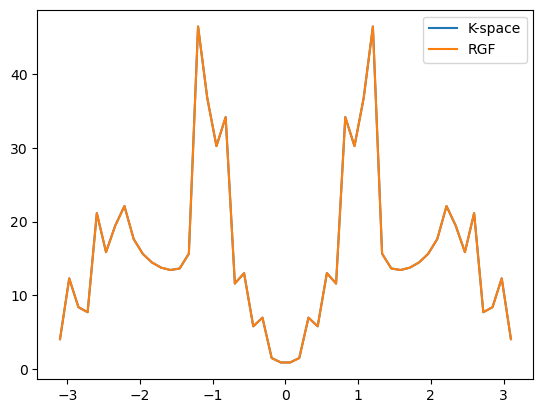

In [16]:
plt.plot(energies, -dosk*4, label="K-space")
plt.plot(energies, dos, label="RGF")
plt.legend()
plt.show()

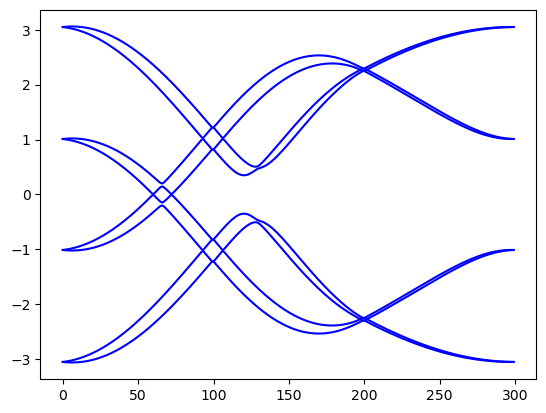

In [44]:
# Plot band structure

G = [0,0]
M = [0, 0.5]
K = [0.5, 0.0]

GR.set_kpath([G,M,K,G],100)

fig, axs = plt.subplots()
bands = GR.get_bands()

for i in range(GR.N_orbs):
    b = bands[:,i]
    axs.plot(b,c='b')


plt.show()

# Testing generalized lattice functionality

## Describe the model
Information about the primitive vectors, orbitals, their positions and the hoppings. The hoppings are defined in the band_structure library and they assume a certain set of orbitals "Au", "Ad", "Bu" and "Bd", in this order. These are the orbitals in the Rashba model defined in the graphene unit cell (just A and B sublattices)

In [2]:
#  _ 
# / \   Graphene unit cell orientation
# \_/

# primitive vectors
a1 = np.sqrt(3)*np.array([np.sqrt(3)/2, 0.5])
a2 = np.sqrt(3)*np.array([0,1])
prims = [a1,  a2]

orbs = [           "Au",            "Ad",            "Bu",            "Bd"]
pos  = [np.array([0,0]), np.array([0,0]), np.array([1,0]), np.array([1,0])]
No = len(orbs)

hops = bs.KuboVsKeldysh()

## Duplicate the unit cell to make it into a nanoribbon

In [3]:
duplicator = rgf.hop_utils()

duplicator.set_prims(prims)
duplicator.set_orbs(orbs, pos)
duplicator.set_hops(hops)

# join unit cell [0,0] with [1,0]
join = [1,0]

# New primitive vectors
A1 = [2,-1]
A2 = [0, 1]

duplicator.set_duplication_rules(join, A1, A2)
duplicator.duplicate_orbs()
duplicator.duplicate_hops()

new_A1 = A1[0]*a1 + A1[1]*a2
new_A2 = A2[0]*a1 + A2[1]*a2
new_prims = [new_A1, new_A2]

ham_struct = [duplicator.new_orbs_dic, duplicator.new_pos, new_prims, duplicator.new_hops]

## Compare with hard-coded functionality

In [6]:
# sample geometry
width=3
length=4

# Boundary conditions. Twist false means open boundary conditions. 
# k is only used when twist=True but it needs to exist
twist = True
k = 0.6
λex = 0.4
λR = 0.3

# Initialize the graphene + Rashba hard-coded system 
gramag = rgf.rgf()
gramag.set_graphene_nanoribbon_rashba(width, length, twist, k, ander=0.0, m=λex, lR=λR)

# Initialize the graphene + Rashba system implemented with the general TB functionality
gramag_gen = rgf.rgf()
gramag_gen.set_system(ham_struct, width, length, twist, k)

C = gramag.C
S = gramag.S

ander = 0
np.random.seed(2)
Anderson = np.random.random([C,S])*ander



gramag.Anderson = Anderson
gramag.build_spin()
gramag.build_vels_hsample()

gramag_gen.Anderson = Anderson
gramag_gen.build_spin2()
gramag_gen.build_vels_hsample()


## Comparing general lattice vs hard-coded Rashba+mag
Comparing the 'h' and 'u' matrices explicitly. The basis is ordered differently in each case, so it has to be reordered so that a clear comparison can be established

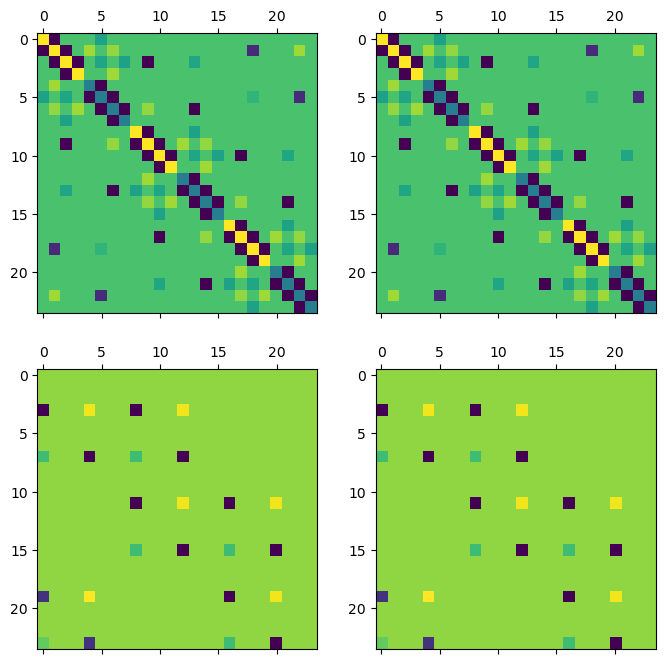

In [7]:
# reorder the basis to compare Hamiltonians exactly
new2old = [0,4,1,5,2,6,3,7]
old2new = [0,2,4,6,1,3,5,7]

No = 8
N = width*No

fun = np.real
h1     = fun(gramag.h)
u1     = fun(gramag.u)
h2temp = fun(gramag_gen.h)
u2temp = fun(gramag_gen.u)
h2 = h1*0.0
u2 = u1*0.0

for i in range(N):
    o1 = i%No
    wi = i//No # line 
    ip = new2old[o1] + No*wi
    
    for j in range(N):
        o2 = j%No
        wj = j//No        
        jp = new2old[o2] + No*wj
        
        h2[ip,jp] = h2temp[i,j]
        u2[ip,jp] = u2temp[i,j]





fig, axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].matshow(h1)
axs[0,1].matshow(h2)
axs[1,0].matshow(u1)
axs[1,1].matshow(u2)
plt.show()

## Comparing H_sample with h and u

The Hamiltonian in the sample must have certain properties which have to be satisfied. This can be used to check whether h and u are well implemented (they weren't...)

(0.1732050807568877-0.09999999999999999j) (0.1732050807568877-0.09999999999999999j)
(0.1732050807568877-0.09999999999999999j) (0.1732050807568877-0.09999999999999999j)


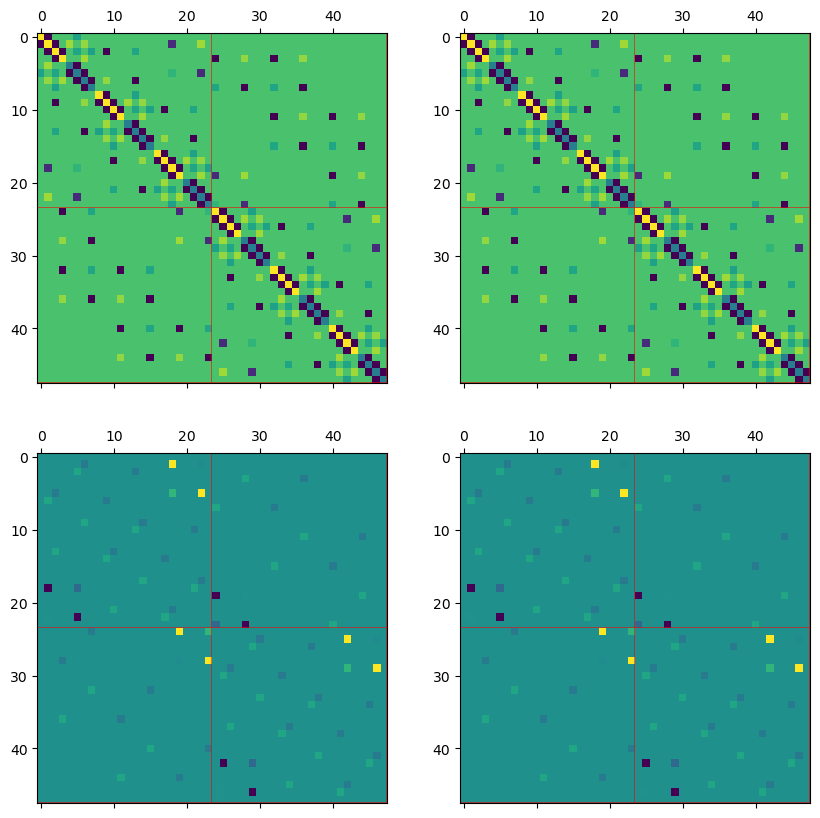

Difference between the hamiltonians 0.0 0.0 0.0


In [8]:

H = gramag.H_sample
Htemp = gramag_gen.H_sample
H_gen = Htemp*0.0

N = len(Htemp)

for i in range(N):
    o1 = i%No
    wi = i//No # line 
    ip = new2old[o1] + No*wi
    
    for j in range(N):
        o2 = j%No
        wj = j//No        
        jp = new2old[o2] + No*wj
        
        H_gen[ip,jp] = Htemp[i,j]

C = width*No

lim = 48
H     =     H[:lim,:lim]
H_gen = H_gen[:lim,:lim]

for ham in [H, H_gen]:
    print(ham[9,14], ham[3,36])

fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].matshow(np.real(H))
axs[0,1].matshow(np.real(H_gen))
axs[1,0].matshow(np.imag(H))
axs[1,1].matshow(np.imag(H_gen))
for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        for n in range(1,length-1):
            ax.axhline(n*C-0.7, c='r', linewidth=0.4)
            ax.axvline(n*C-0.7, c='r', linewidth=0.4)
plt.show()

difference_H = np.sum(np.abs(H_gen - H))
difference_h = np.sum(np.abs(h1 - h2))
difference_u = np.sum(np.abs(u1 - u2))
print("Difference between the hamiltonians", difference_H, difference_h, difference_u)


## Comparing transport properties

In [15]:
# Choose the operator
n = 2 # slice
a = C*n
b = a+C

# Operators
vx = gramag.vx[a:b,a:b]
vy = gramag.vy[a:b,a:b]
sx = gramag.spinx[a:b,a:b]
sy = gramag.spiny[a:b,a:b]

vx_gen = gramag_gen.vx[a:b,a:b]
vy_gen = gramag_gen.vy[a:b,a:b]
sx_gen = gramag_gen.spinx[a:b,a:b]
sy_gen = gramag_gen.spiny[a:b,a:b]


# Operator in the slice
op_local = np.zeros([C,C], dtype=complex)
op_local_gen = np.zeros([C,C], dtype=complex)

op_local = sx*1.0
op_local_gen = sx_gen*1.0


# Operator in the slice, but as part of the whole sample
op_sample = np.zeros([C*S, C*S], dtype=complex)
op_sample[a:b,a:b] = op_local

op_sample_gen = np.zeros([C*S, C*S], dtype=complex)
op_sample_gen[a:b,a:b] = op_local_gen

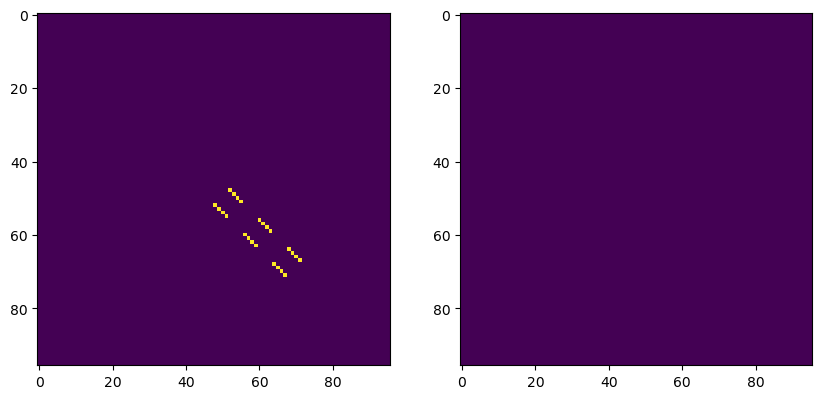

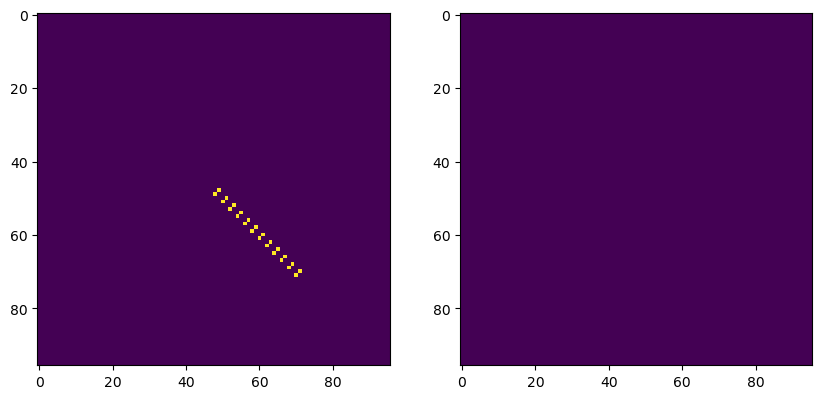

In [16]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(np.real(op_sample))
axs[1].imshow(np.imag(op_sample))
plt.show()


fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(np.real(op_sample_gen))
axs[1].imshow(np.imag(op_sample_gen))
plt.show()

In [17]:
# list of complex energies
eta = 1e-5
NE = 20
energies = np.linspace(0,4, NE)
zs = energies + eta*1j

greenwood     = gramag.kubo_greenwood(zs, op_sample, gramag.vx)
greenwood_gen = gramag_gen.kubo_greenwood(zs, op_sample_gen, gramag_gen.vx)


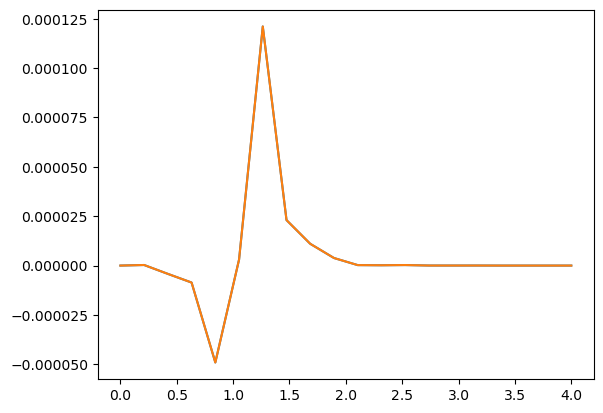

In [18]:
plt.plot(energies, np.real(greenwood))
plt.plot(energies, np.real(greenwood_gen))
plt.show()

## Integral
Not working..

In [ ]:
def integral(mu,a,b):
    # a,b - eigen energies
    tol = 1e-9
    
    d = a-b
    x = d/(mu - b)
    y = 0
    
    if np.abs(d) < tol:
        y = -(1.0/2.0/(mu-b)**2 + d/3.0/(mu-b)**3)
        
    else:
        y = (np.log(1-x) + x)/(d**2)

    return y

# Four total integrals contribute
def total_int(mu,en,em):
    I1 =  integral(mu,en - 1j*eta, em + 1j*eta)
    I2 =  integral(mu,en - 1j*eta, em - 1j*eta)
    I3 = -integral(mu,en + 1j*eta, em + 1j*eta)
    I4 = -integral(mu,en + 1j*eta, em - 1j*eta)
    
    return I1 + I2 + I3 + I4
    

In [ ]:
NE = 4
lim = 3
mus = np.linspace(-lim, lim, NE)

finite_cond = np.zeros(NE, dtype=complex)
Imatrix = np.zeros([N,N], dtype=complex)

def get_finite_cond(mu):
    soma = 0
    eigs = gramag.vals0
    for n in range(N):
        en = eigs[n]
        for m in range(N):
            em = eigs[m]
            I = total_int(mu, en, em)
            soma += I*op_KS[n,m]
            
    return soma
            
for i,mu in enumerate(mus):
    print(mu)
    finite_cond[i] = get_finite_cond(mu)

In [ ]:
print(finite_cond)
plt.plot(mus, np.real(finite_cond))
plt.show()
# plt.plot(mus, np.imag(finite_cond))

## Integrator

In [ ]:
class bastin_integrator():
    # Simple adaptive integrator
    
    energies1 = -1
    energies = -1
    bastingrand = -1
    bastin = -1
    quiet = False
    
    de = -1 # must be set
    
    def __init__(self, fun, operator):
        # self.recursive = obj # Object of the rgf class
        self.fun = fun # function to be evaluated to integrate
        self.op = operator*1.0 
        
        
    def calc_stuff(self, z):
        b1 = self.fun(z, self.op, self.de)[0]
        if not self.quiet:
            print(f"{np.real(z[0]):5.5f}",end=" ")
        return b1
    
    def set_integrator(self, energies1, energies, de):
        self.energies1 = energies1*1.0 # integrand
        self.energies  = energies*1.0 # list of fermi energies
        self.de = de
        self.prev = energies*1j*0

In [ ]:
def integrator(self, tol, eta1min, eta1max):
    # The integrand gets evaluated for smaller and smaller eta in order to accurately
    # find the peaks. The initial value of the broadening is "eta1max", and it gets 
    # divided by 3 each time, until it is smaller than eta1min
    
    # energies1 is the set of energies over which the integrand is evaluated
    NE1 = len(self.energies1)
    

    eta1 = eta1max
    do = True
    while eta1 > eta1min:
        do = False
        # Update eta

        # Comment this block if you just want to redo the algorithm for the last eta
        eta1 /= 3

        # Calculate the integrand parallelized
        zs1 = self.energies1 + eta1*1j
        bast = []
        with Pool(8) as p:
            bast = p.map(self.calc_stuff, list(np.array([z]) for z in zs1))
        self.bastingrand = np.array(bast)

        if not self.quiet:
            print("###################### ETA ",eta1,"###############################")
        else:
            print("eta", eta1)




        # Calculate the integral
        self.bastin = np.zeros(NE, dtype=complex)
        for i,mu in enumerate(self.energies):
            self.bastin[i] = rgf.cond(mu, self.energies1, self.bastingrand)

        # Refine the integrand
        while True:

            # Identify the points with large derivatives
            der = self.bastingrand[1:] - self.bastingrand[:-1]
            ens = self.energies1[1:] - self.energies1[:-1]
            var = np.abs(der)
            
            # General overview
            if not self.quiet:
                fig, axs = plt.subplots(1,3,figsize=(12,4))
                axs[0].set_title("Real bastingrand")
                axs[1].set_title("Imag bastingrand")
                axs[0].plot(self.energies1, np.real(self.bastingrand))
                axs[1].plot(self.energies1, np.imag(self.bastingrand))
                axs[2].plot(self.energies1[:-1], var)
                for i in self.energies1:
                    for j in range(3):
                        axs[j].axvline(i, alpha=0.01, color='red')
                plt.show()
                print("#########################################################################################################")
                print(len(self.energies1), len(self.bastingrand), np.sum(var*ens))

            # Create a new point in the middle of each problematic pair of points
            points = []
            pointsz = []
            bast = []
            count = 0
            for i in range(NE1-1):
                v = var[i]*ens[i]
                if v > tol:

                    e1 = self.energies1[i]
                    e2 = self.energies1[i+1]
                    e = (e1+e2)/2

                    count += 1

                    points.append(e)
                    z = e + 1j*eta1
                    z = np.array([z])
                    pointsz.append(z)


            # Calculate the integrand in the new set of points
            with Pool(8) as p:
                bast = p.map(self.calc_stuff, pointsz)


            # If no new points have been found within this tolerance, go to next eta
            if count == 0:    
                if not self.quiet:
                    print("found no points")
                break


            # Add the new energies and integrand values to the current list
            new_energies    = np.array(points + list(self.energies1  ))
            new_bastingrand = np.array(bast   + list(self.bastingrand))
            size = len(new_energies)

            res = np.zeros([size, 2], dtype=complex)
            res[:,0] = new_energies
            res[:,1] = new_bastingrand

            if not self.quiet:
                print("size of new energies: ", size)
            
            new = res[res[:, 0].argsort()]

            NE1 = size
            self.energies1 = np.real(new[:,0])
            self.bastingrand = new[:,1]


            # Recalculate the integral
            self.bastin = np.zeros(NE, dtype=complex)
            for i,mu in enumerate(self.energies):
                self.bastin[i] = rgf.cond(mu, self.energies1, self.bastingrand)

            # General view of the new integral and comparison with Kubo-Greenwood
            if not self.quiet:
                fig, axs = plt.subplots(1,3,figsize=(15,4))

                axs[0].set_title("Real")
                axs[1].set_title("Imag")
                axs[2].set_title("Bastin - prev")
                axs[0].plot(self.energies, np.real(self.bastin))
                axs[0].plot(self.energies, np.real(self.prev),'--')
                axs[1].plot(self.energies, np.imag(self.bastin))
                axs[1].plot(self.energies, np.imag(self.prev),'--')
                axs[2].plot(self.energies, np.imag(self.prev-self.bastin),'--')
                plt.show()


            # If the maximum difference between two iterations is sufficiently small
            # then go to the next eta
            maxdif = np.max(np.abs(self.prev-self.bastin))
            prev = self.bastin*1.0 # save the previous value to establish a comparison in the next iteration
            if not self.quiet:
                print("MAXDIF",maxdif)
                
            if maxdif < 1e-2:
                print("done")
                break


    print("Reached smallest eta")
    
bastin_integrator.integrator = integrator

### done

In [ ]:
bassea = bastin_integrator(gramag.kubo_sea2, op_sample)
bassea.quiet = False
energies1 = np.linspace(-4,6,500) # initial set of energy points for the adaptive integrator
de = 1e-6 # derivative to be used in Kubo-Bastin
bassea.set_integrator(energies1, mus, de)

# tol, eta1min, eta1max
bassea.integrator(0.01, eta*1.001, eta*27)
plt.plot(mus, np.imag(bassea.bastin))
plt.show()

In [ ]:


fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(mus, np.real(finite_cond))
axs[0].plot(mus, np.real(bassea.bastin))

axs[1].plot(mus, np.imag(finite_cond))
axs[1].plot(mus, np.imag(bassea.bastin))
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].plot(bassea.energies1, np.real(bassea.bastingrand))
axs[1].plot(bassea.energies1, np.imag(bassea.bastingrand))
axs[0].plot(energies, np.real(integrand), 'o', markersize=4)
axs[1].plot(energies, np.imag(integrand), 'o', markersize=4)
plt.show()

In [ ]:
NE = 200
lim = 5
mus1 = np.linspace(-lim, lim, NE)

integrated_RGF = np.zeros(NE, dtype=complex)
for i,mu in enumerate(mus1):
    integrated_RGF[i] = rgf.cond(mu, bassea.energies1, bassea.bastingrand)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].plot(mus1, np.real(integrated_RGF))
axs[1].plot(mus1, np.imag(integrated_RGF))
axs[0].axhline(0, c='k', linestyle='--')
axs[1].axhline(0, c='k', linestyle='--')
plt.show()